In [43]:
import numpy as np
import pandas as pd
import rwi

from sklearn.decomposition import PCA

import xgboost as xgb
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from xgboost import plot_importance

In [3]:
import rwi
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [4]:
def load_df(name):
    eurusd_df = pd.read_csv(name)
    eurusd_df = eurusd_df.rename(columns={'<TICKER>':'Ticker', '<DTYYYYMMDD>':'Date', '<TIME>':'Time', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Vol'})
    eurusd_df[['Date']] = pd.to_datetime(eurusd_df['Date'].astype('str'), yearfirst=True)
    eurusd_df =eurusd_df.sort_values(by=['Date', 'Time'])
    eur_df = eurusd_df[['Date', 'Time', 'Close', 'Open', 'High', 'Low', 'Vol']].rename(columns={'Close':'Close'})
    eur_df['Change'] = eur_df['Close'].pct_change()
    eur_df.dropna(inplace=True)
    #eur_df = eur_df[eur_df.Date>'2020-01-01']
    #eur_df = eur_df.set_index('Date')
    return eur_df

In [5]:
import FinanceDataReader as fdr

In [6]:
#sp500 = fdr.DataReader('US500', start = '2009-01-01')

In [7]:
#sp500.to_csv('SP500.csv', encoding='utf-8')

In [143]:
sp500 = pd.read_csv('SP500.csv', encoding='utf-8')
sp500['Date'] = pd.to_datetime(sp500['Date'], yearfirst=True)
sp500 = sp500.set_index('Date')
#sp500 = sp500.loc[:'2019-12-31']
sp500['price'] = sp500['Close']

In [144]:
sp500 = sp500.resample('W').last()

In [145]:
sp500 = rwi.generate_features(sp500)

In [146]:
sp500['atr_5'] = sp500.returns.rolling(5).std()
sp500['atr_20'] = sp500.returns.rolling(20).std()
sp500['atr_50'] = sp500.returns.rolling(50).std()
sp500['range'] = 100*(sp500['High'] - sp500['Low'])/sp500['Low']
sp500['adj_close'] = sp500['Close'] / (sp500['High']*0.5 + sp500['Low']*0.5)
sp500['adj_close'] = sp500['adj_close'].replace([np.inf, -np.inf, 0], 0)



In [147]:
sp500.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'price', 'returns',
       'ROC_2', 'ROC_3', 'ROC_5', 'ROC_20', 'ROC_50', 'ROC_100', 'ROC_200',
       'ROC_500', 'abs_returns', 'atr_5', 'atr_20', 'atr_50', 'range',
       'adj_close'],
      dtype='object')

In [148]:
sp500.drop(columns=['ROC_100', 'ROC_200',
       'ROC_500'], inplace=True)

In [149]:
#sp500 = pd.get_dummies(sp500, columns=['month', 'day', 'week_day'])

In [150]:
sp500.loc[:,'shift_returns'] = sp500['returns'].shift(-1)

sp500.dropna(inplace=True) # .fillna(0, inplace=True)#

In [151]:

sp500 = sp500[sp500.shift_returns != 0.0]


In [152]:
sp500.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'price', 'returns',
       'ROC_2', 'ROC_3', 'ROC_5', 'ROC_20', 'ROC_50', 'abs_returns', 'atr_5',
       'atr_20', 'atr_50', 'range', 'adj_close', 'shift_returns'],
      dtype='object')

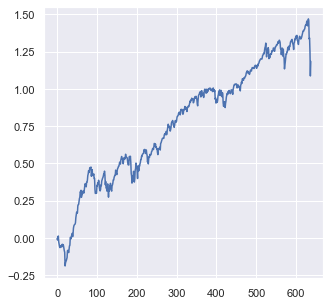

In [153]:
neg = len(sp500[sp500.shift_returns < 0])
pos = len(sp500[sp500.shift_returns > 0])
under_df = sp500[sp500.shift_returns < 0].sample(pos-neg) 
sp500 = pd.concat([under_df, sp500])
sp500.reset_index().returns.cumsum().plot()

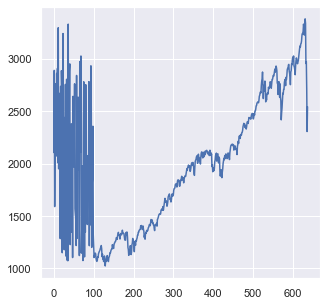

In [154]:
sp500.reset_index().price.plot()

In [155]:
sp500.drop(columns=['Close', 'Open', 'High', 'Low', 'Volume', 'price', 'range', 'adj_close', 'Change'], inplace=True)

In [220]:

X = sp500.drop(columns='shift_returns')
y = sp500['shift_returns']

In [221]:


y = np.sign(y)

X = X.select_dtypes('number')


In [222]:
X_train=X.iloc[:int(X.shape[0] * 0.75)]
y_train = y[:int(X.shape[0] * 0.75)]
X_test = X.iloc[int(X.shape[0] * 0.80):]
y_test = y[int(X.shape[0] * 0.80):]
#X_train, X_test, y_train, y_test = train_test_split(  X, y, test_size=0.20, random_state=42)

In [223]:
X_train=X.iloc[:-60]
y_train = y[:-60]
X_test = X.iloc[-50:]
y_test = y[-50:]

In [159]:
X.shape[0] * 0.80 - X.shape[0] * 0.75

31.900000000000034

In [47]:
params = {
        'min_child_weight': [1, 2, 3, 5, 7, 10],
        'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 , 0.5, 1, 1.5, 2, 5],
        'subsample': [0.1, 0.3, 0.5, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.1, 0.3, 0.4, 0.5, 0.7, 0.6, 0.8, 1.0],
        'max_depth': [3,  5,  8,  12, 15, 50],
        "learning_rate"    : [0.001, 0.01, 0.1, 0.2, 0.5],
        "eta" : [0.001, 0.01, 0.1, 0.2, 0.3],
        "n_estimators":[1000]
        }

In [180]:
model = xgb.XGBClassifier(n_jobs=5)

In [49]:
import time

In [53]:
n_iter_search = 10000
random_search = RandomizedSearchCV(model, param_distributions=params,
                                   n_iter=n_iter_search,  cv=StratifiedKFold( n_splits=5, shuffle=True) ,
                   scoring='roc_auc',
                   verbose=2, refit=True, n_jobs=5)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))


Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   13.0s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   36.7s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed:  4.8min
[Parallel(n_jobs=5)]: Done 3271 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed:  7.4min
[Parallel(n_jobs=5)]: Done 4891 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 5822 tasks      | elapsed: 10.4min
[Parallel(n_jobs=5)]: Done 6835 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 7928 tasks      | elapsed: 13.8min
[Parallel(n_jobs=5)]: Done 9103 tasks      | elapsed: 15.7min

RandomizedSearchCV took 5638.11 seconds for 10000 candidates parameter settings.


In [56]:
random_search.best_score_ # for auc

0.5906039215686274

In [57]:
random_search.best_estimator_ # for auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eta=0.1, gamma=1,
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=5,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=1)

In [224]:
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eta=0.01, gamma=1,
              learning_rate=0.001, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=5,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eta=0.01, gamma=1,
              learning_rate=0.001, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=5,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=1)

In [225]:
y_pred = model.predict(X_test)

In [234]:
score = model.score(X_test, y_test)

In [235]:
score

0.46

In [236]:
from sklearn.metrics import roc_auc_score
rf_probs = model.predict_proba(X_test)[:, 1]
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)

In [237]:
# we have to reove low tf indicators
print(score, roc_value)

0.46 0.5763546798029557


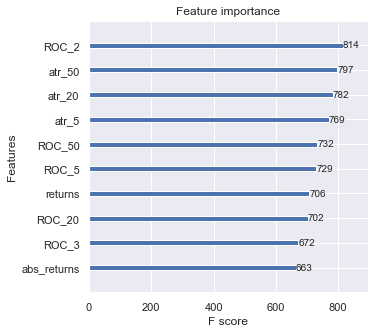

In [189]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [209]:
X_test=X_test.reset_index()

In [203]:
sp500.head()

,Date,returns,ROC_2,ROC_3,ROC_5,ROC_20,ROC_50,abs_returns,atr_5,atr_20,atr_50,shift_returns
0,2015-03-01,-0.002752,0.003575,0.023573,0.025351,0.099003,0.133698,0.002752,0.022360,0.019822,0.016356,-0.015921
1,2019-08-18,-0.010322,-0.014902,-0.046396,-0.042392,0.018969,-0.004435,0.010322,0.017199,0.018053,0.023789,-0.014495
2,2013-04-14,0.022642,0.012451,0.020320,0.023995,0.120024,0.124141,0.022642,0.012315,0.013204,0.017036,-0.021374
3,2016-10-23,0.003828,-0.005858,-0.012582,0.000935,0.019825,0.019791,0.003828,0.008617,0.012184,0.018580,-0.006913
4,2018-02-04,-0.039309,-0.017289,-0.008691,0.032573,0.099619,0.161093,0.039309,0.026430,0.013021,0.010530,-0.053000


In [210]:
X_test['Date']

0     2018-02-25
1     2018-03-04
2     2018-03-11
3     2018-03-18
4     2018-03-25
         ...    
105   2020-03-01
106   2020-03-08
107   2020-03-15
108   2020-03-22
109   2020-03-29
Name: Date, Length: 110, dtype: datetime64[ns]

In [217]:
X_test

,Date,returns,ROC_2,ROC_3,ROC_5,ROC_20,ROC_50,abs_returns,atr_5,atr_20,atr_50,shift_returns,pred,direction,res
0,2018-02-25,0.005504,0.047616,-0.005384,-0.022673,0.074788,0.146632,0.005504,0.040435,0.020344,0.014303,NaN,-1.0,NaN,NaN
1,2018-03-04,-0.020613,-0.015109,0.027003,-0.065306,0.052670,0.123641,0.020613,0.037848,0.021060,0.014686,-0.014495,-1.0,-1.0,0.014495
2,2018-03-11,0.034806,0.014193,0.019697,0.008809,0.078880,0.172961,0.034806,0.039476,0.022234,0.015170,NaN,-1.0,NaN,NaN
3,2018-03-18,-0.012480,0.022326,0.001713,0.049329,0.064128,0.152518,0.012480,0.027880,0.022535,0.015321,NaN,-1.0,NaN,NaN
4,2018-03-25,-0.061346,-0.073826,-0.039020,-0.054129,0.000162,0.094216,0.061346,0.035354,0.026765,0.017810,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2020-03-01,-0.122062,-0.134688,-0.119050,-0.109314,-0.005418,0.045619,0.122062,0.059888,0.031047,0.023140,NaN,-1.0,NaN,NaN
106,2020-03-08,0.006125,-0.115937,-0.128563,-0.081735,-0.004642,0.059487,0.006125,0.061191,0.031054,0.023117,NaN,-1.0,NaN,NaN
107,2020-03-15,-0.092035,-0.085910,-0.207972,-0.204959,-0.108776,-0.044505,0.092035,0.062067,0.037032,0.026551,NaN,1.0,NaN,NaN
108,2020-03-22,-0.162279,-0.254314,-0.248189,-0.382877,-0.285625,-0.227158,0.162279,0.071732,0.050623,0.034838,NaN,1.0,NaN,NaN


In [196]:
sp500 = sp500.reset_index()

In [218]:
X_test['shift_returns'] = sp500[sp500['Date'].isin(X_test['Date'])]['shift_returns'] #sp500.loc[X_test.reset_index().index]['shift_returns']
X_test['pred'] = y_pred
X_test['direction'] = np.sign(X_test.shift_returns)
X_test['res'] = X_test.shift_returns  * X_test['pred']

C:\Users\lexik\.conda\envs\NN\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


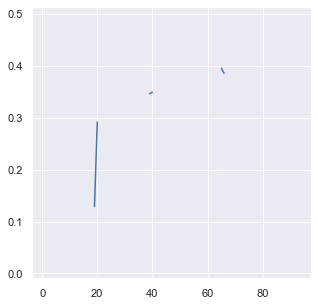

In [219]:
# 10h
(X_test.res.cumsum()).plot()

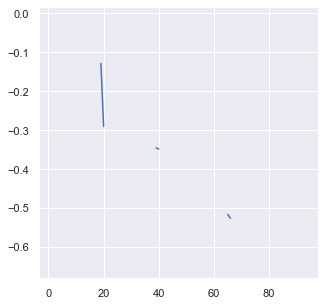

In [215]:
X_test.reset_index().shift_returns.cumsum().plot()

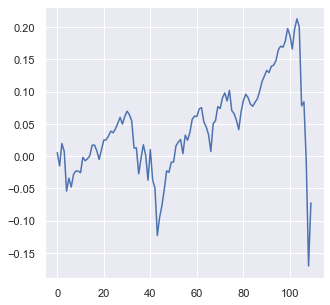

In [216]:
X_test.reset_index().returns.cumsum().plot()

In [32]:

# use PCA custering to improve accuracy of results

In [69]:
def apply_pca(X_):
    
    pca = PCA(n_components=3,  random_state=40)

    pca_X = pca.fit_transform(X_.fillna(0)) 

    #print(pca.explained_variance_ratio_)

    #print(pca.singular_values_)
    pca_X = pd.DataFrame(pca_X, columns=['p1', 'p2', 'p3'])
    return pca_X

def kmeans(pca_X_, n_clusters):
    kmeans = KMeans(n_clusters, random_state=40).fit(pca_X_)
    

    y_ = kmeans.predict(pca_X_)
    #kmeans.labels_
    #kmeans.cluster_centers_
    return y_

def evaluate(df_, cond, cluster,  n_clusters, sampling, idx):
    
    count = df_[(df_.entry==1) & cond ].reset_index().val.count()
    prop = df_[(df_.entry==1) & cond & (df.val > 0) ].val.count() / ( df[(df.entry==1) & cond & (df.val > 0) ].val.count() + df[(df.entry==1) & cond & (df.val < 0) ].val.count())
    total_ret = df_[(df_.entry==1) & cond ].reset_index().val.sum()
    sharpe_ratio = (252* df_[(df_.entry==1) & cond ].reset_index().val.mean()) / (df_[(df_.entry==1) & cond ].reset_index().val.std() * np.sqrt(252)) 
    profit_factor = df_[(df_.entry==1) & (cond) & (df_.val > 0)].val.sum() / df_[(df_.entry==1) & cond & (df_.val < 0)].val.abs().sum()
    
    max_drw = df_[(df_.entry==1) & cond ].reset_index().val.cumsum().min()
    max_rsk = df_[(df_.entry==1) & cond ].reset_index().val.min()
    volat = df_[(df_.entry==1) & cond ].reset_index().val.std() * np.sqrt(252)
    
    plots_idx[str(idx)+'_'+str(x)] = df_[(df_.entry==1) & cond ].reset_index().val.cumsum()
    
    return (count, prop, total_ret, sharpe_ratio, profit_factor, max_drw, max_rsk, volat, idx,   n_clusters, cluster,  ','.join(sampling))


In [70]:
X_train.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'price', 'returns',
       'ROC_2', 'ROC_3', 'ROC_5', 'ROC_20', 'ROC_50', 'abs_returns', 'atr_5',
       'atr_20', 'atr_50', 'range', 'adj_close'],
      dtype='object')

In [153]:
cols = ['ROC_20', 'ROC_50', 'atr_20', 'atr_50']
pca_X = apply_pca(X_train[cols])
kmeans = KMeans(6, random_state=40).fit(pca_X)
pca_X = apply_pca(X_test[cols])
clusters = kmeans.predict(pca_X)
X_test['clusters'] = clusters

C:\Users\lexik\.conda\envs\NN\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


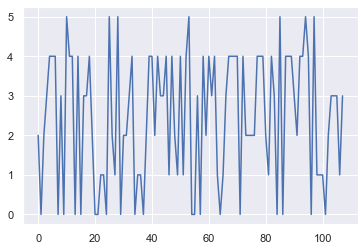

In [154]:
X_test.reset_index().clusters.plot()

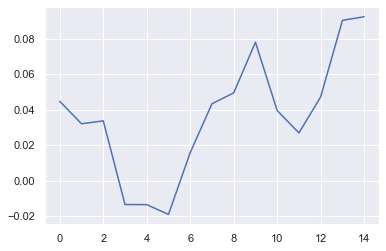

In [155]:
X_test[X_test.clusters==1].reset_index().res.cumsum().plot()

In [144]:
X_test['res_bin'] = np.sign(X_test.res)

C:\Users\lexik\.conda\envs\NN\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


AxesSubplot(0.125,0.125;0.775x0.755)


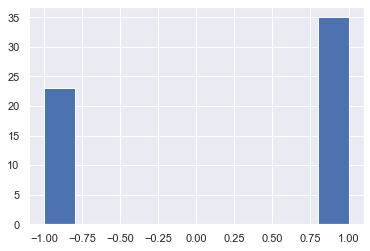

In [146]:
print(X_test[X_test.clusters==1].res_bin.hist())

In [167]:
X_test[X_test.clusters==5].groupby(X_test.res_bin).count()

,Close,Open,High,Low,Volume,Change,price,returns,ROC_2,ROC_3,...,atr_20,atr_50,range,adj_close,shift_returns,pred,direction,res,clusters,res_bin
res_bin,,,,,,,,,,,,,,,,,,,,,
-1.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1.0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [169]:
4 / (3+4)

0.5714285714285714

In [152]:
35/(35+23)

0.603448275862069

In [106]:
#0
17.5/(17.5+7.5)

0.7

In [109]:
# 1
14/(10+14)

0.5833333333333334

In [111]:
# 2
30 / (30+26)

0.5357142857142857

In [68]:
# swithc from Xgboost to LSTM
# test
# swithc from PCA to VAE
# do backtesting step by step

In [170]:
"""
backtesting:
1. momentum and mean-reversal strategies
2. MAs cross-over
3. ML prediction returns aggregation
4. ML prediction + regime returns aggregation
5. Adding stop losses and tp to optimize returns of ML model

"""

'\nbacktesting:\n1. momentum and mean-reversal strategies\n2. MAs cross-over\n3. ML prediction returns aggregation\n4. ML prediction + regime returns aggregation\n5. Adding stop losses and tp to optimize returns of ML model\n\n'

In [171]:
# ppt and prepare visualizations